# Assignment 5: Dimensionality Reduction and Performance Evaluation

In [1]:
# enter your name and UFL email address
name = 'Yang Bai'
email = 'baiyang94@ufl.edu'

In [2]:
if name == 'enter your name' or email == 'enter your email':
    assert False, 'Enter your name & email first!'
else:
    print('Assignment 5 -- name: {}, email: {}\n'.format(name, email))
    
    # Load packages we need
    import sys
    import os
    import time

    import numpy as np
    import pandas as pd
    import sklearn
    
    # we'll use keras for neural networks
    import tensorflow.keras as keras
    from tensorflow.keras.datasets import mnist

    from matplotlib import pyplot as plt
    plt.rcParams.update({'font.size': 16})

    # Let's check our software versions
    print('### Python version: ' + __import__('sys').version)
    print('### NumPy version: ' + np.__version__)
    print('### Scikit-learn version: ' + sklearn.__version__)
    print('------------')


    # load our packages / code
    sys.path.insert(1, '../common/')
    import utils
    import plots

Assignment 5 -- name: Yang Bai, email: baiyang94@ufl.edu

### Python version: 3.8.3 (default, Jul  2 2020, 11:26:31) 
[Clang 10.0.0 ]
### NumPy version: 1.19.5
### Scikit-learn version: 0.23.1
------------


In [3]:
# global parameters to control behavior of the pre-processing, ML, analysis, etc.
seed = 42

# deterministic seed for reproducibility
##rng = np.random.default_rng(seed)  # best practice but not fully implemented in scikit-learn
np.random.seed(seed)

prop_vec = [24, 2, 2]

## Part 1: Loading and Pre-processing Data

### For this assignment we'll use the MNIST dataset, which contains images of handwritten digits.
### The task is to predict what digit a given image contains

### Loading data

In [4]:
"""
## Load and preprocess the MNIST dataset
"""
def load_preprocess_mnist_data(flatten=True, onehot=True, prop_vec=[26, 2, 2], seed=None, verbose=False):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    if verbose:
        # MNIST has overall shape (60000, 28, 28) -- 60k images, each is 28x28 pixels
        print('Loaded MNIST data; shape: {} [y: {}], test shape: {} [y: {}]'.format(x_train.shape, y_train.shape,
                                                                                      x_test.shape, y_test.shape))
    
    if flatten:
        # Let's flatten the images for easier processing (labels don't change)
        flat_vector_size = 28 * 28
        x_train = x_train.reshape(x_train.shape[0], flat_vector_size)
        x_test = x_test.reshape(x_test.shape[0], flat_vector_size)

    if onehot:
        # Put the labels in "one-hot" encoding using keras' to_categorical()
        num_classes = 10
        y_train = tf.keras.utils.to_categorical(y_train, num_classes)
        y_test = tf.keras.utils.to_categorical(y_test, num_classes)

    # let's aggregate all the data then split
    all_x = np.r_[x_train, x_test]
    all_y = np.r_[y_train, y_test]
    
    # split the data into train, test, val
    train_x, train_y, test_x, test_y, val_x, val_y = utils.train_test_val_split(all_x, all_y, prop_vec, shuffle=True, seed=seed)
    return train_x, train_y, test_x, test_y, val_x, val_y, all_x, all_y

In [5]:
# grab the data
train_x, train_y, test_x, test_y, val_x, val_y, all_x, all_y = load_preprocess_mnist_data(onehot=False, prop_vec=prop_vec, seed=seed)

# sanity check shapes
train_x.shape, train_y.shape, test_x.shape, test_y.shape, val_x.shape, val_y.shape

((60000, 784), (60000,), (5000, 784), (5000,), (5000, 784), (5000,))

## [Task 1] (30 points) Visualization and Preprocessing Data

### [Task 1a] (5 points) Show the first training example. What does it look like?

In [6]:
###* put your code here (~1 line) *###
print(train_x[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0  48  86  85 117 225 146   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0  13  73 227 253 252
 252 252 252   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0  26 156 252 252 240 223 114  84  84   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0  63 240 252 252 173
  63   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0  13 191 255 253 253 178  63   0   0   

### [Task 1b] (5 points) How are the features represented? What is the range of values for each feature?

In [7]:
###* put your answer here *###
#
# Answer:
# The features are represented in an array of shades of gray. 
# Each value represents the shade of a pixel in the image.
# The range of each feature is from 0 to 255 corresponding to black to white.
# 

### [Task 1c] (10 points) Use plot_images() to plot the first 81 examples of the training data.

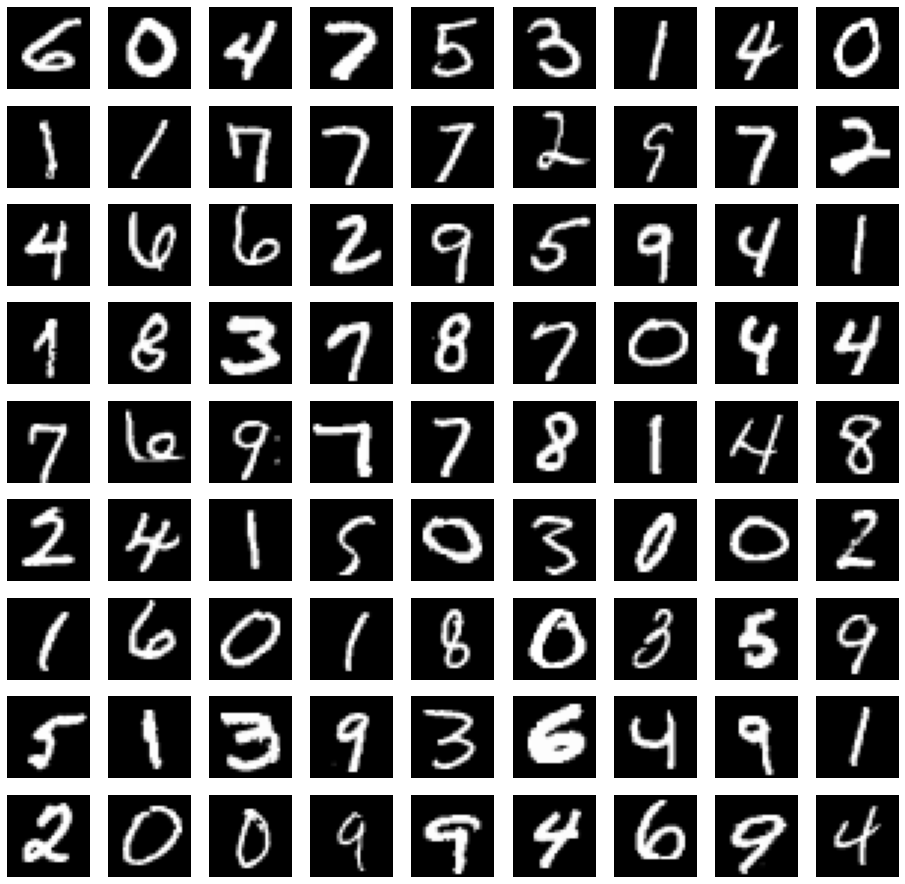

In [8]:
### Hint: you will need to reshape the examples in the way plots.plot_images() expects.
###* put your code here (~1-2 line) *###
plots.plot_images(train_x[0:81].reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(16,16))

### [Task 1d] (5 points) Rescale all the data features (all_x) such that each feature is in the range [0,1]. Store the results in 'all_x_rescaled'. Then, split the data again into train, test, validation.

In [9]:
### After rescaling, don't forget to split the data again into train, test, validation 
### (use the same seed and store the result in train_x, train_y, test_x, test_y, val_x, val_y)
###* put your code here (~2-3 lines) *###
from sklearn.preprocessing import MinMaxScaler
scaler_minmax = MinMaxScaler()
all_x_rescaled = scaler_minmax.fit(all_x).transform(all_x)
train_x, train_y, test_x, test_y, val_x, val_y = train_x, train_y, test_x, test_y, val_x, val_y = utils.train_test_val_split(all_x_rescaled, all_y, prop_vec, shuffle=True, seed=seed)

In [10]:
assert np.amax(all_x_rescaled.ravel()) == 1 and np.amax(train_x.ravel()) == 1 and np.amax(val_x.ravel()) == 1
assert np.amin(all_x_rescaled.ravel()) == 0 and np.amin(train_x.ravel()) == 0 and np.amin(val_x.ravel()) == 0
assert train_x.shape == (60000, 784) and train_y.shape == (60000,)
assert test_x.shape == (5000, 784) and test_y.shape == (5000,)
assert val_x.shape == (5000, 784) and val_y.shape == (5000,)

### [Task 1e] (5 points) Now use plot_images() again to plot the first 81 examples of the training data. What do you observe? Is this expected?

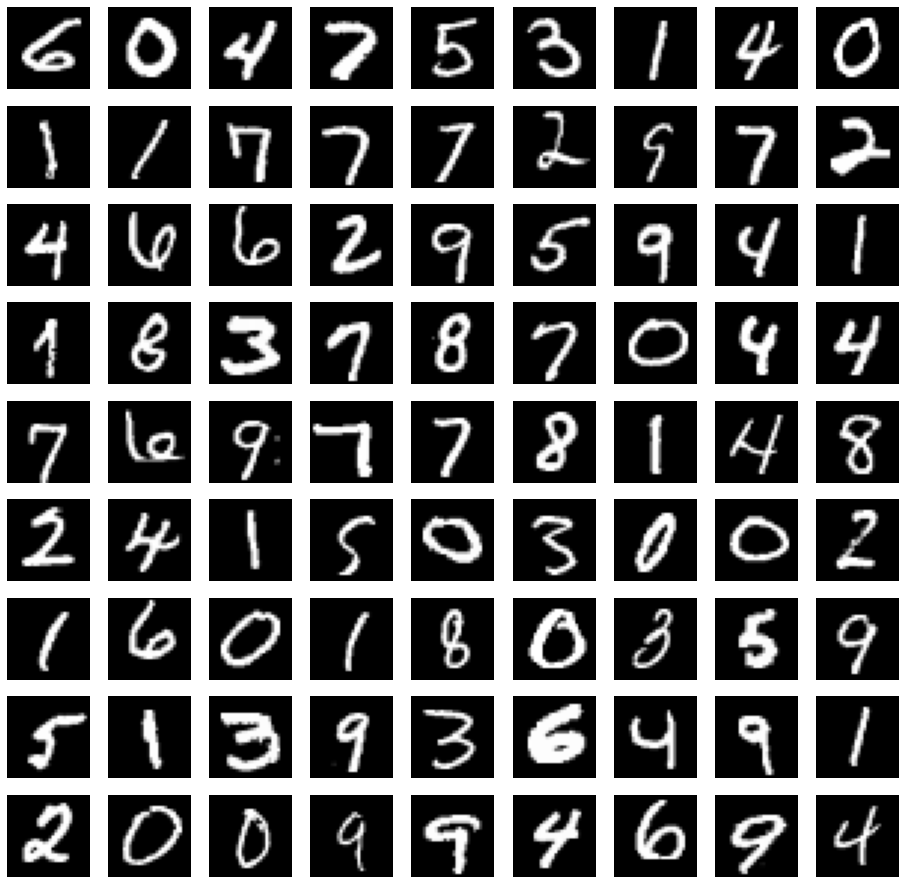

In [11]:
###* put your code here (~1-2 lines) *###
plots.plot_images(train_x[0:81].reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(16,16))


### What do you observe? Is this expected?
###* put your answer here *###
#
# Answer:
# I boserve that the scaled examples look super similar to the unscaled examples.
# This is not expected by me, because the scaled shade of each pixel is in the range of 0 to 1 where every pixel 
# should be black, but in the result of plot_images(), I can still see lots of white pixels in the exaples.
# I think it is becuase the imageshow() function in the plot_images() did some trickes to recover the scaled 
# images to normal grayscale images.
# 

## [Task 2] (10 points) Training and Evaluating Classifiers

### [Task 2a] (5 points) Fill in the implementation of val_acc_class_report_error_analysis() below.

In [12]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

def val_acc_class_report_error_analysis(name, model, val_x, val_y, accuracy_only=False):
    pred_y  = model.predict(val_x)
    cm = confusion_matrix(val_y, pred_y)

    print('Model: {}'.format(name))
    
    ### Use the confusion matrix to compute (using NumPy) the accuracy (call the result 'val_acc')
    ### Note: recall that accuracy is the trace of the matrix divided by the number of examples
    ###* put your code here (~1-2 lines) *###
    val_acc = np.trace(cm) / np.sum(cm)    
    
    print('--- Validation accuracy: {: .2f}%\n'.format(val_acc*100))
    
    if accuracy_only:
        return
    
    classes = [str(d) for d in range(0, 10)]
    print('--- Classification Report: ')
    
    ### Print the classification report with 3 digits of precision
    ### Hint: use sklearn's classification_report() 
    ###* put your code here (~1-2 lines) *###
    print(classification_report(val_y, pred_y, digits=3))

          
    fig = plt.figure(figsize=(10,8))
    ax = plt.gca()
    plot_confusion_matrix(model, val_x, val_y, cmap='bone', ax=ax)
    plt.show()

### [Task 2b] (5 points) Train the decision tree classifier on the training data, call the result model 'dtmodel'

In [13]:
### Train the decision tree classifier on the training data (default hyperparameters), call the result model 'dtmodel'
###* put your code here (~1-2 lines) *###
from sklearn.tree import DecisionTreeClassifier
dtmodel = DecisionTreeClassifier(random_state=seed).fit(train_x, train_y)

Model: Decision Tree
--- Validation accuracy:  87.80%

--- Classification Report: 
              precision    recall  f1-score   support

           0      0.921     0.937     0.929       507
           1      0.952     0.960     0.956       596
           2      0.861     0.823     0.842       491
           3      0.865     0.891     0.878       525
           4      0.876     0.868     0.872       463
           5      0.849     0.830     0.839       446
           6      0.891     0.899     0.895       475
           7      0.893     0.886     0.890       528
           8      0.833     0.836     0.834       494
           9      0.816     0.823     0.820       475

    accuracy                          0.878      5000
   macro avg      0.876     0.875     0.875      5000
weighted avg      0.878     0.878     0.878      5000



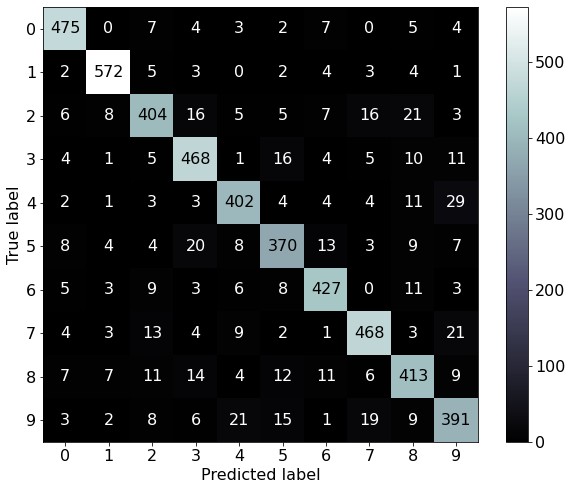

In [14]:
val_acc_class_report_error_analysis('Decision Tree', dtmodel, val_x, val_y)

## [Task 3] (30 points) PCA

### [Task 3a] (15 points) Use PCA to reduce the dimensionality of the data (use 'all_x_rescaled'). Ensure the number of principal components is such that 95% of the variance is explained. You can use NumPy/SciPy or Sklearn. Ensure that you determine the PCA transformation using only the training data ('train_x'), but apply the transformation to 'all_x_rescaled'. Store the PCA transformed data into 'all_x_pca' and the number of principal components in 'k'.

In [15]:
###* put your code here (~4+ lines) *###
from sklearn.decomposition import PCA

for k in range(152, 156):
    pca_decomp = PCA(n_components=k, whiten=True).fit(train_x)
    all_x_pca = pca_decomp.transform(all_x_rescaled)
    explained_var = np.sum(pca_decomp.explained_variance_ratio_)

    print('Explained variance (k={}): {: .3f}%'.format(k, explained_var*100))
    
    if explained_var >= 0.95:
        break

Explained variance (k=152):  94.910%
Explained variance (k=153):  94.946%
Explained variance (k=154):  95.001%


In [16]:
assert all_x_pca.shape ==  (70000, k)
assert k >= 152 and k <= 155

In [17]:
# Split the PCA data
train_x_pca, train_y, test_x_pca, test_y, val_x_pca, val_y = utils.train_test_val_split(all_x_pca, all_y, prop_vec, shuffle=True, seed=seed)

### [Task 3b] (5 points) Print the first example in the training set (for the PCA transformed data).

In [18]:
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})

###* put your code here (~1 line) *###
print(train_x_pca[0])
print("Shape of feature vector: ", train_x_pca.shape)
print("Range of features: (%.3f, %.3f)" % (np.amin(train_x_pca[0]), np.amax(train_x_pca[0])))

[ 0.67 -0.51  1.44  0.80 -0.78 -0.88  0.26  0.22  2.37  0.52 -0.26 -0.10
 -1.03  0.11 -1.38  2.08 -0.98 -1.25  1.05  1.81 -1.23  0.58 -0.51 -0.49
 -2.10  1.08 -1.42  0.52  1.90 -0.19  0.52 -1.35 -3.10 -0.91 -2.13  0.58
  1.80 -0.60  0.81 -1.28  0.15 -0.35 -0.66  1.23  0.16  0.80  0.57 -4.14
  0.46  0.67 -0.65 -1.92 -1.33  0.53 -0.29  0.92  0.45  3.44 -0.43  1.67
  1.80 -0.87  1.17 -0.62  0.50 -0.93  2.11  1.51 -1.94 -1.90 -1.57  0.67
  0.95  1.39  0.27 -0.22 -0.36 -0.38 -0.81 -1.03  2.36 -0.98  0.41  0.66
 -0.26  0.05  2.96 -0.21  0.26  0.08 -2.26 -0.54 -0.71  0.53  0.36  0.34
 -0.34  1.29  1.44 -0.86  1.01 -0.81 -0.55  1.00 -2.71 -0.29  0.32 -0.65
  2.23 -0.49 -1.36  0.62  2.79  0.96  0.28  2.00  0.67  1.79  0.35  0.40
  0.86 -0.62 -0.63 -0.23 -1.03 -0.58 -1.12  0.06  0.09 -0.71  1.03  0.36
 -1.61 -0.96  1.98  0.99 -1.23  0.09  0.04  1.03 -1.50 -1.49  0.84 -0.15
  0.20  0.24 -1.95  1.25 -1.29 -2.51  0.75 -0.53  0.71 -0.79]
Shape of feature vector:  (60000, 154)
Range of features: (-4.

### [Task 3c] (5 points) What do you observe? What is the range of features? Is that expected?

In [19]:
###* put your answer here *###
#
# Answer:
# I observe that the feature vector in the PCA transformed data has smaller dimansion, 
# but it is much denser then the original one.
# The range of features is now from -4.144 to 3.443.
# This is expected.
#

### [Task 3d] (5 points) Apply the inverse PCA transformation on train_x_pca and plot the 81 first examples of the reconstructed training data using plot_images()

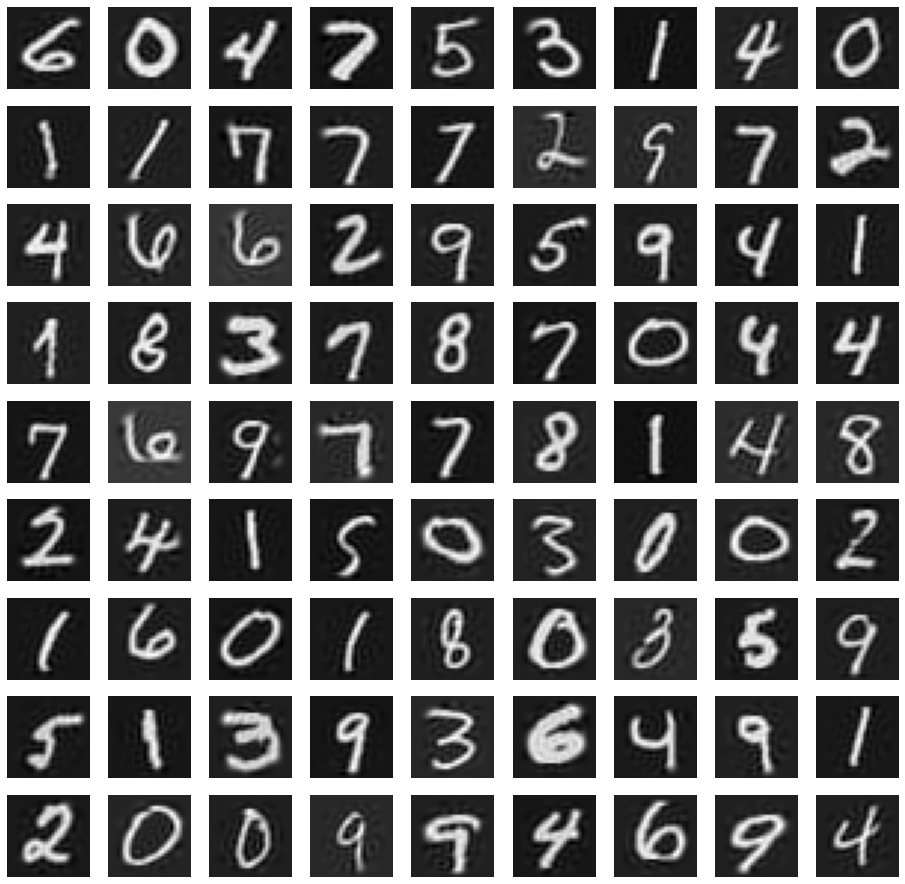

In [20]:
###* put your code here (~2-3 lines) *###

inv_tr100 = pca_decomp.inverse_transform(train_x_pca[0:81])
plots.plot_images(inv_tr100.reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(16,16))

## [Task 4] (30 points) Training and Evaluating Classifiers on the PCA transformed data

### [Task 4a] (25 points) Choose 3 classifiers (and their hyperparameters) and train them on both the original data and the PCA transformed data.

In [21]:
from sklearn.base import clone

models = []
tr_sz = None

### Instantiate the models you want to use (with whatever you hyperparameters you like) and append them to 'models'
### Note: to speed up the training process if you want to use models that are slow to train, you can 
### set 'tr_sz' so that training uses only a subset of the training data
### (You will have to import the classifiers you want to use.)
###* put your code here (~6+ lines) *###

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

model_knn = KNeighborsClassifier(n_neighbors=3)
model_lr = LogisticRegression(max_iter=500, random_state=seed, C=0.001)
model_rf = RandomForestClassifier(max_depth=10, random_state=seed)

models = [model_knn, model_lr, model_rf]

# The following code will train and evaluate the classifiers you selected.
if tr_sz is None:
    tr_sz = train_x.shape[0]
    
for i, model in enumerate(models):
    m = clone(model)
    m.fit(train_x[0:tr_sz], train_y[0:tr_sz])
    val_acc_class_report_error_analysis(str(m), m, val_x, val_y, accuracy_only=True)
    
    m = clone(model)
    m.fit(train_x_pca[0:tr_sz], train_y[0:tr_sz])
    val_acc_class_report_error_analysis('PCA - {}'.format(m), m, val_x_pca, val_y, accuracy_only=True)

Model: KNeighborsClassifier(n_neighbors=3)
--- Validation accuracy:  97.22%

Model: PCA - KNeighborsClassifier(n_neighbors=3)
--- Validation accuracy:  90.76%

Model: LogisticRegression(C=0.001, max_iter=500, random_state=42)
--- Validation accuracy:  89.32%

Model: PCA - LogisticRegression(C=0.001, max_iter=500, random_state=42)
--- Validation accuracy:  89.28%

Model: RandomForestClassifier(max_depth=10, random_state=42)
--- Validation accuracy:  94.34%

Model: PCA - RandomForestClassifier(max_depth=10, random_state=42)
--- Validation accuracy:  91.42%



### [Task 4b] (5 points) What do you observe? Which is the best classifier? Does using the PCA transformed data make any difference?

In [22]:
###* put your answer here *###
#
# Answer:
# I observe that different model has different response to the PCA transformed data:
# the performance of the KNeighborsClassifier drops a lot;
# the performance of the LogisticRegression increased a little bit;
# the performace of the RandomForestClassifier drops a little bit.
# The best classifier is the RandomForestClassifier without using the PCA transformed data.
#

## [CIS6930 Additional Task -- Task 5] (25 points): More Dimensionality Reduction

### [Task 5a] (25 points) Pick any dimensionality reduction technique other than PCA. This can be KernelPCA (with any kernel other than linear), LLE, MDS, Isomap, t-SNE, etc. (whatever you like really as long it can be used for dimensionality reduction).  Then transform 'all_x_rescaled' using that method. Split the transformed data again into train, test, val. Then train and evaluate the same models as you did for Task 4a.

### Can you find a technique and hyperparameters such that the performance of the classifiers on the reduced dimension data is similar to their performance on the original data?

### *Note: The point of this task is (in part) to get you to explore different dimensionality reduction techniques and how to use them with sklearn. That said, any reasonable choice of technique and hyperparameters is acceptable for this task as long as it is implemented correctly. *

In [ ]:
### To save time/memory, it is acceptable to fit your dimensionality reduction technique on a subset of the training data
### Don't forget that you need to train and evaluate models on the transformed data!
###* put your code here (~10+ lines) *###
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE

k = 154
print("fitting the traning data with KernelPCA...")
kernelPCA_decomp = KernelPCA(kernel='rbf', n_components=k).fit(train_x)
print("Done")

print("Transforming the all_x_rescaled...")
all_x_kernelPCA = kernelPCA_decomp.transform(all_x_rescaled)
print("Done")
print("Splitting the data...")
train_x_kernelPCA, train_y, test_x_kernelPCA, test_y, val_x_kernelPCA, val_y = utils.train_test_val_split(all_x_kernelPCA, all_y, prop_vec, shuffle=True, seed=seed)
print("Done")
# tsne_decomp = TSNE(n_components=k, init='pca', random_state=seed).fit(train_x)
# all_x_tsne = tsne_decomp.fit_transform(all_x_rescaled)
# train_x_tsne, train_y, test_x_tsne, test_y, val_x_tsne, val_y = utils.train_test_val_split(all_x_tsne, all_y, prop_vec, shuffle=True, seed=seed)


model_knn = KNeighborsClassifier(n_neighbors=3)
model_lr = LogisticRegression(max_iter=500, random_state=seed, C=0.001)
model_rf = RandomForestClassifier(max_depth=10, random_state=seed)

models = [model_knn, model_lr, model_rf]
tr_sz = None

if tr_sz is None:
    tr_sz = train_x.shape[0]

for i, model in enumerate(models):
    m = clone(model)
    m.fit(train_x[0:tr_sz], train_y[0:tr_sz])
    val_acc_class_report_error_analysis(str(m), m, val_x, val_y, accuracy_only=True)
    
    m = clone(model)
    m.fit(train_x_pca[0:tr_sz], train_y[0:tr_sz])
    val_acc_class_report_error_analysis('kernelPCA - {}'.format(m), m, val_x_pca, val_y, accuracy_only=True)

fitting the traning data with KernelPCA...
